In [1]:
!pip install -U imbalanced-learn
!pip install phik -q
!pip install shap

     |████████████████████████████████| 258 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 63.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01


# Проект: Предсказание стартапов

<b>Цель проекта:</b> разработать модель машинного обучения для предсказания продолжения деятельности стартапа. А так же провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

<b>Этапы проекта: </b>
   1. Открыть файлы с данными.
   2. Провести предобработку данных.
   3. Провести исследовательский анализ данных.
   4. Провести корреляционный анализ признаков данных.
   4. Обучить несколько моделей и выбрать лучшую.
   2. Оценить важность признаков.

<b> Описание данных: </b>  
Работа ведется с двумя датасетами.  


`kaggle_startups_train_01.csv` - информация (53 000) о стартапах, которые будут использоваться в качестве обучающих данных.  
`kaggle_startups_test_01.csv` - информация (13 000) о стартапах, которые будут использоваться в качестве тестовых данных.  

Описание полей данных  
* `name` - Название стартапа. Идентификатор.  
* `category_list` - Список категорий, к которым относится стартап.  
* `funding_total_usd` - Общая сумма финансирования в USD.  
* `status` - Статус стартапа (закрыт или действующий), целевой признак.  
* `country_code` - Код страны.  
* `state_code` - Код штата.  
* `region` - Регион.  
* `city` - Город.  
* `funding_rounds` - Количество раундов финансирования.  
* `founded_at` - Дата основания.  
* `first_funding_at` - Дата первого раунда финансирования.  
* `last_funding_at` - Дата последнего раунда финансирования.  
* `closed_at` - Дата закрытия стартапа (если применимо).  
* `lifetime` - Время существования стартапа в днях.  

### Загрузка данных


Импортируем библиотеки

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import phik
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
import shap
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import Ridge, LinearRegression
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [3]:
# Определение констант
RANDOM_STATE = 42
END_OF_DATE = '2018-01-01'

Загружаем данные

In [4]:
data_train = pd.read_csv('kaggle_startups_train_28062024.csv')
data_test = pd.read_csv('kaggle_startups_test_28062024.csv')

Посмотрим на общую информацию и на первые 5 строк датасетов

In [5]:
display (data_train.info())
display (data_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [6]:
display (data_test.info())
display (data_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


В работе будет использоваться 2 датафрейма. В обоих датафремах необходимо преобразовать столбцы с датами (`founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`) в формат datetime для удобства работы с датами. В таблице data_train необходимо рассчитать время существования стартапа в днях на основе даты основания.

### Предобработка данных

#### Проверка дубликатов

Проверим наличие явных дубликатов и дубликатов в поле `name` в тренировочном датасете.

In [7]:
print (f'Количество явных дубликатов: {data_train.duplicated().sum()}')
print (f'Количество дубликатов в столбце name: {data_train["name"].duplicated().sum()}')

Количество явных дубликатов: 0
Количество дубликатов в столбце name: 0


#### Проверка пустых значений

Проверим наличие пустых значений в тренировочной таблице.

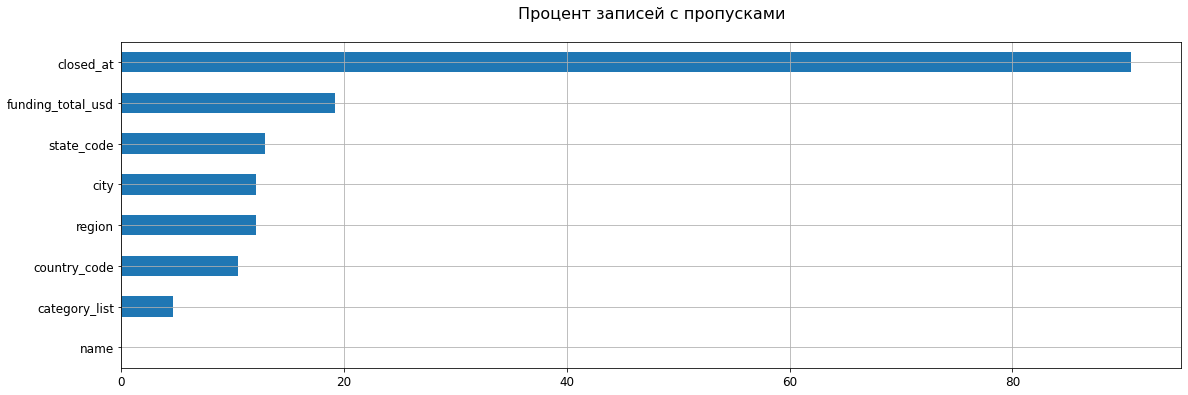

In [8]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 12, grid = True)
            .set_title('Процент записей с пропусками' + "\n", fontsize = 16) 
           );    
    except:
        display('пропусков не осталось')
        
pass_value_barh(data_train)

В тренировочном датасете, в некоторых строках отсутствуют значения для столбцов `name`, `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`, `closed_at`.
Особенно много пропусков в столбце `closed_at`.

Заполним пропуски в столбце `closed_at`. Датой закрытия будем считать дату выгрузки 01.01.2018.  
Пропуски в столбце `funding_total_usd` заполним 0 и разделим на 1000000 для упрощения вычислений.

In [9]:
data_train['closed_at'] = data_train['closed_at'].fillna(END_OF_DATE)
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(0)
data_train['funding_total_usd'] = data_train['funding_total_usd'] / 1000000

Сразу приведем столбцы с датой к соответствующему формату и рассчитаем время существования стартапа в днях.

In [10]:
def datetime(df, columns, date_format='%Y-%m-%d'):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format=date_format)
    return df

data_train = datetime(data_train, ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

data_train['lifetime'] = (data_train['closed_at'] - data_train['founded_at']).dt.days

Пропуски в `name`, `category_list`, `country_code`, `state_code`, `region`, `city` заполним значением "unknown". Пропуски заполним в пайплайне.

In [11]:
# Создаем пайплайн для обработки пропущенных значений
nan_pipeline = Pipeline([
    
    ('fillna_unknown', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),    
])

columns_to_transform = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']

# Применяем пайплайн к выбранным столбцам
data_train[columns_to_transform] = nan_pipeline.fit_transform(data_train[columns_to_transform])

По аналогии с предыдущими действиями проверим и обработаем пропуски в таблице `data_test`.

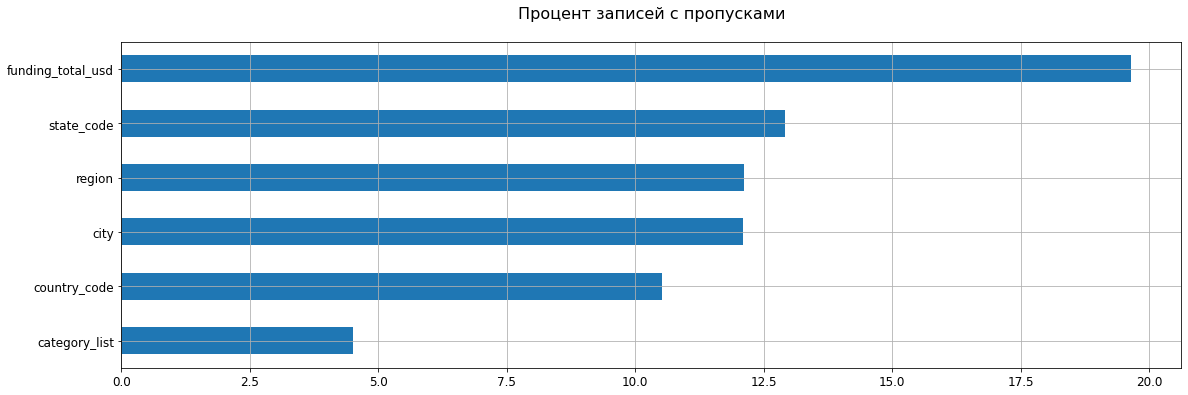

In [12]:
pass_value_barh(data_test)

В тестовом датасете, в некоторых строках также отсутствуют значения. Есть пропуски для столбцов `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`. Больше всего пропусков в столбце `funding_total_usd`.

In [13]:
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(0)
data_test[columns_to_transform] = nan_pipeline.fit_transform(data_test[columns_to_transform])
data_test['category_list'] = data_test['category_list'].str.split('|').str[0]
data_test = datetime(data_test, ['first_funding_at', 'last_funding_at'])
data_test['funding_total_usd'] = data_test['funding_total_usd'] / 1000000

#### Проверка уникальных значений

Посмотрим на уникальные значения в столбце `category_list`

In [14]:
data_train['category_list'].nunique()

22106

In [15]:
data_train['category_list'].unique()

array(['Online Reservations|Restaurants',
       'Manufacturing|Medical|Medical Devices', 'Biotechnology', ...,
       'Gambling|Games|Online Gaming|Sports',
       'Aerospace|Mobile|Transportation|Travel',
       'Online Rental|Parking|Price Comparison'], dtype=object)

Приведем написание всех категорий к нижнему ригистру и заменим символ ' & ' на слово 'and'

In [16]:
data_train['category_list'] = data_train['category_list'].str.lower()
data_train['category_list'] = data_train['category_list'].str.replace(' & ', 'and')

Мы создадим словарь, в котором будут отражены основные слова из категорий, и сгруппируем их для упрощения анализа. В дальнейшем этот словарь, не смотря на большой объем, будет удобно дополнять и редактировать.

In [17]:
category_map = {
    'social': 'social',
    'service': 'social',
    'demographies': 'social',
    'commu': 'social',
    'retirement': 'social',
    'forum': 'social',
    'women': 'social',
    'gener': 'social',
    'senior': 'social',
    'survey': 'social',
    'charit': 'social',
    'bab': 'social',
    'young': 'social',
    'speak': 'social',
    'parenting': 'social',
    'families': 'social',
    'security': 'social',
    'fraud': 'social',
    'match': 'social',
    'kids': 'social',
    'indians': 'social',
    'polling': 'social',
    'politic': 'social',
    'alumni': 'social',
    'identity': 'social',
    'insurance': 'social',
    'government': 'social',
    'analytic': 'social',
    'opinion': 'social',
    'local': 'social',
    'translation': 'social',
    'chat': 'social',
    'care': 'social',
    'relig': 'social',
    'messag': 'social',
    'collabor': 'social',
    'incentives': 'social',
    'mobility': 'social',
    'infrastructure': 'social',
    'iaas': 'social',
    'assisted': 'social',
    'sns': 'social',
    'q&a': 'social',   
    'center': 'social',  
    'public': 'social',
    'law': 'social', 
    'privacy': 'social', 
    'health': 'health',
    'doctor': 'health',
    'therap': 'health',
    'beauty': 'health',
    'medical': 'health',
    'medicin': 'health',
    'clinic': 'health',
    'dental': 'health',
    'hosp': 'health',
    'fertility': 'health',
    'swimming': 'health',
    'exercise': 'health',
    'pharm': 'health',
    'physi': 'health',
    'diagn': 'health',
    'genetic': 'health',
    'fitness': 'health',
    'cosmetic': 'health',
    'psy': 'health',
    'diabetes': 'health',
    'wellness': 'health',
    'sports': 'health',
    'lingerie': 'health',
    'soccer': 'health',
    'dietary': 'health',
    'tech': 'tech',
    'rfid': 'tech',
    'augmented': 'tech',
    'wireless': 'tech',
    'technolog': 'tech',
    'internet': 'tech',
    'elect': 'tech',
    'ict': 'tech',   
    'saas': 'tech',
    'ios': 'tech',
    'time': 'tech',
    'biometrics': 'tech',
    'developer': 'tech',
    'bioinformati': 'tech',
    'android': 'tech',
    'corporate it': 'tech',
    'algorithms': 'tech',
    'browser': 'tech',
    'm2m': 'tech',
    'ipad': 'goods and services',
    'app': 'tech',
    'military': 'tech',
    'linux': 'education & science',
    'cad': 'tech',
    'peer': 'tech',
    'paas': 'tech',
    'digital': 'tech',
    'system': 'tech',
    'smart': 'tech',
    'ware': 'tech',
    'user': 'tech',
    'utilities': 'tech',
    'mechanical': 'tech',
    'semiconductors': 'tech',
    'virtual': 'tech',
    'nutrition': 'health',
    'iphone': 'goods and services',
    'qr': 'tech',
    'cloud': 'tech',
    'data': 'tech',
    'robot': 'tech',
    'comp': 'goods and services',
    'mobile': 'tech',
    'email': 'marketing',
    '3d': 'tech',
    'aerospace': 'education & science',
    'displays': 'goods and services',
    'automat': 'tech',
    'kinect': 'tech',
    'gadget': 'education & science',
    'video': 'tech',
    'prin':'tech',
    'cyber':'tech',
    'file':'tech',
    'voip':'tech',
    'industrial':'tech',
    'drones':'tech',
    'recognition':'tech',
    'education': 'education & science',
    'learn': 'education & science',
    'humanitarian': 'education & science',
    'colleg': 'education & science',
    'schoo': 'education & science',
    'universit': 'education & science',
    'edutainment': 'education & science',
    'artists': 'education & science',
    'chemical': 'education & science',
    'training': 'education & science',
    'tutor': 'education & science',
    'science': 'education & science',
    'skill': 'education & science',
    'veterinary': 'education & science',
    'optimization': 'education & science',
    'synchronization': 'education & science',
    'ediscovery': 'education & science',
    'architecture': 'education & science',
    'accounting': 'education & science',
    'self': 'education & science',
    'intellectual': 'education & science',
    'engineer': 'education & science',
    'construction': 'education & science',
    'finan': 'finance',
    'bank': 'finance',
    'pay': 'finance',
    'monetization': 'finance',
    'credit': 'finance',
    'money': 'finance',
    'invest': 'finance',
    'fund': 'finance',
    'owners': 'finance',
    'consumer': 'finance',
    'commerce': 'finance',
    'brokers': 'finance',
    'trading': 'finance',
    'auctions': 'finance',
    'business': 'finance',
    'ticketing': 'finance',
    'ventur': 'finance',
    'exchange': 'finance',
    'quoting': 'finance',
    'coin': 'finance',
    'firm': 'finance',
    'debt': 'finance',
    'entrepreneur': 'finance',
    'capital': 'finance',
    'sponsorship': 'finance',
    'online': 'tech',
    'web': 'tech',
    'simulation': 'education & science',
    'media': 'media & entertainment',
    'entertainment': 'media & entertainment',
    'film': 'media & entertainment',
    'music': 'media & entertainment',
    'gam': 'media & entertainment',
    'books': 'media & entertainment',
    'wedd': 'media & entertainment',
    'life': 'media & entertainment',
    'news': 'media & entertainment',
    'even': 'media & entertainment',
    'gift': 'media & entertainment',
    'telev': 'media & entertainment',
    'photo': 'media & entertainment',
    'audio': 'media & entertainment',
    'fashion': 'media & entertainment',
    'celebrity': 'media & entertainment',
    'collectibles': 'media & entertainment',
    'lotteries': 'media & entertainment',
    'handmade': 'media & entertainment',
    'home': 'media & entertainment',
    'design': 'media & entertainment',
    'creative': 'media & entertainment',
    'cooking': 'media & entertainment',
    'art': 'media & entertainment',
    'concert': 'media & entertainment',
    'landscaping': 'media & entertainment',
    'diy': 'media & entertainment',
    'leisure': 'media & entertainment',
    'brewing': 'media & entertainment',
    'content': 'media & entertainment',
    'publishing': 'media & entertainment',
    'contests': 'media & entertainment',
    'restaurants': 'media & entertainment',
    'journalism': 'media & entertainment',
    'reputation': 'media & entertainment',
    'broadcasting': 'media & entertainment',
    'travel': 'tourism',
    'rental': 'tourism',
    'hotel': 'tourism',
    'spas': 'tourism',
    'guid': 'tourism',
    'maps': 'tourism',
    'recreation': 'tourism',
    'resort': 'tourism',
    'cars': 'transport',
    'fuel': 'transport',
    'air': 'transport', 
    'shipping': 'transport', 
    'bicycle': 'transport',
    'ride': 'transport',
    'transportation': 'transport',
    'parking': 'transport',
    'racing': 'transport',
    'automotive': 'transport',
    'geospatial': 'transport',
    'gps': 'transport',
    'navigation': 'transport',
    'taxis': 'transport',
    'limousines': 'transport',
    'boat': 'transport',
    'blog': 'social',
    'stud': 'education & science',
    'manag': 'management',
    'human': 'management',
    'enterprise': 'management',
    'coworking': 'management',
    'network': 'management',
    'logistic': 'management',
    'employ': 'management',
    'recruiting': 'management',
    'crowdsourcing': 'management',
    'outsourcing': 'management',
    'legal': 'management',
    'governance': 'management',
    'source': 'management',
    'freelancers': 'management',
    'solar': 'eco',
    'seed': 'eco',
    'organic': 'eco',
    'energ': 'eco',
    'water': 'eco',
    'oil': 'eco',
    'recycl': 'eco',
    'green': 'eco',
    'natural': 'eco',
    'carbon': 'eco',
    'agriculture': 'eco',
    'environmental': 'eco',
    'incubator': 'eco',
    'processing': 'eco',
    'gas': 'eco',
    'farming': 'eco',
    'mineral': 'eco',
    'aquaculture': 'eco',
    'mark': 'marketing',
    'sale': 'marketing',
    'buy': 'marketing',
    'retail': 'marketing',
    'vending': 'marketing',
    'toy': 'marketing',
    'coupon': 'marketing',
    'realtor': 'marketing',
    'personal': 'marketing',
    'golf': 'marketing',
    'shopping': 'marketing',
    'loyalty': 'marketing',
    'industry': 'marketing',
    'presentations': 'marketing',
    'discounts': 'marketing',
    'delivery': 'marketing',
    'product': 'marketing',
    'platform': 'marketing',
    'price': 'marketing',
    'procurement': 'marketing',
    'estate': 'marketing',
    'b2b': 'marketing',
    'fmcg': 'marketing',
    'freemium': 'marketing',
    'advertising': 'marketing',
    'promo': 'marketing',
    'distribu': 'marketing',
    'customization': 'marketing',
    'reviews': 'marketing',
    'crm': 'marketing',
    'targeting': 'marketing',
    'billing': 'marketing',
    'seo': 'marketing',
    'customer': 'marketing',
    'flower': 'goods and services',    
    'tea': 'goods and services',
    'products': 'goods and services',
    'shoes': 'goods and services',
    'foods': 'goods and services',
    'coffee': 'goods and services',
    'eyewear': 'goods and services',    
    'cannabis': 'goods and services',
    'furniture': 'goods and services',
    'comics': 'goods and services',
    'jewelry': 'goods and services',
    'batteries': 'goods and services',
    'pets': 'goods and services',    
    'auto': 'transport',     
    'manufacturing': 'goods and services', 
    'groceries': 'goods and services', 
    'material': 'goods and services', 
    'plumbers': 'goods and services', 
    'fruit': 'goods and services',    
    'watch': 'goods and services',
    'gold': 'goods and services',
    'classifieds': 'goods and services',
    'wine': 'goods and services',
    'advice': 'goods and services',
    'graph': 'goods and services',
    'beer': 'goods and services',    
    'textil': 'goods and services',
    'feed': 'goods and services',
    'cable': 'goods and services',
    'registrar': 'goods and services',
    'domains': 'goods and services',
    'angels': 'goods and services',
    'wearables': 'goods and services',   
    'lasers': 'goods and services',
    'storage': 'goods and services',
    'portals': 'goods and services',
    'sensors': 'goods and services',
    'goods': 'goods and services',
    'licensing': 'goods and services',
    'test': 'goods and services',
    'indoor': 'goods and services',
    'rapidly': 'goods and services',
    'office': 'goods and services',
    'commodities': 'goods and services',   
    'defense': 'goods and services',
    'search': 'goods and services',
    'glass': 'goods and services',
    'equipment': 'goods and services',
    'sms': 'goods and services',
    'model': 'goods and services',
    'outdoors': 'goods and services',    
    'lighting': 'goods and services',
    'distribution': 'goods and services',
    'archiving': 'goods and services',
    'tracking': 'goods and services',
    'nonprofits': 'goods and services',
    'consulting': 'goods and services',
    'non profit': 'goods and services',
    'usability': 'goods and services',
    'eda tools': 'goods and services',
    
}

In [18]:
# Функция для замены категорий по маппингу
def replace_categories(categories):
    categories = categories.split(',')
    new_categories = []
    for category in categories:
        replaced = False
        for key in category_map:
            if key in category:
                new_categories.append(category_map[key])
                replaced = True
                break
        if not replaced:
            new_categories.append(category)
    new_categories = list(dict.fromkeys(new_categories))
    new_categories.sort()
    return ', '.join(new_categories)

# Заменить символ '|' на ',' и применить замену категорий
data_train['category_list'] = data_train['category_list'].str.replace('|', ', ').apply(replace_categories)

In [19]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,"media & entertainment, tech",0.828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998
1,EarLens,"goods and services, health",42.935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,tech,35.456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,social,22.250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,goods and services,0.000000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791


In [20]:
data_train['category_list'].nunique()

1228

In [21]:
data_train['category_list'].unique()

array(['media & entertainment, tech', 'goods and services, health',
       'tech', ...,
       'eco, education & science, finance, goods and services, tech',
       ' teenagers, goods and services, social, tech',
       'goods and services, health, marketing, media & entertainment, social, tech'],
      dtype=object)

В результате применения функции, количество категорий уменьшилось с 22106 до 1228

Посмотрим на уникальные значения в столбце `country_code`

In [22]:
display (data_train['country_code'].unique())
display (data_train['country_code'].nunique())

array(['CHE', 'USA', 'unknown', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY',
       'PRT', 'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB',
       'SRB', 'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD',
       'UZB', 'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN',
       'HND', 'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT',
       'IRN', 'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM',
       'TGO', 'R

135

In [23]:
display (data_train['region'].unique())
display (data_train['region'].nunique())

array(['Zurich', 'SF Bay Area', 'unknown', ..., 'Haywards Heath',
       'Herzogenaurach', 'Doncaster'], dtype=object)

1037

Можно сгруппировать страны по регионам на основе кодов их стран.

In [24]:
def group_by_region(country_code):
    regions = {
        'North America': ['USA', 'CAN', 'MEX'],
        'South America': ['ARG', 'BRA', 'CHL', 'COL', 'PER', 'URY', 'VEN', 'PRY', 'ECU'],
        'Europe': ['CHE', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'HUN', 'FIN', 'PRT', 'NLD', 'IRL', 'DEU', 'EST', 'BEL', 'DNK', 'ITA', 'GRC', 'ROM', 'AUT', 'LVA', 'NOR', 'HRV', 'LUX', 'SVN', 'POL', 'CZE', 'ISL', 'LIE', 'LTU', 'CYP', 'MKD', 'GIB', 'SRB', 'ALB', 'MDA', 'MAF', 'GGY', 'JEY'],
        'Asia': ['IND', 'KOR', 'TWN', 'CHN', 'ISR', 'JPN', 'TUR', 'SGP', 'MYS', 'VNM', 'PHL', 'THA', 'BGD', 'LBN', 'IDN', 'KAZ', 'IRN', 'QAT', 'ARE', 'SAU', 'JOR', 'UZB', 'ARM', 'TGO', 'RWA', 'BRN', 'SOM', 'CMR', 'MNE', 'SYC'],
        'Africa': ['EGY', 'NGA', 'GHA', 'UGA', 'ZAF', 'DZA', 'TUN', 'KEN', 'MOZ', 'MAR', 'TAN', 'ZMB'],
        'Oceania': ['AUS', 'NZL', 'FJI'],
        'Central America and the Caribbean': ['CUB', 'DOM', 'GRD', 'PRI', 'TTO', 'BLZ', 'BMU', 'PAN', 'SLV', 'HND', 'NCA', 'CRC', 'GUY', 'HTI', 'JAM', 'KNA', 'BHS', 'BRB', 'DMA', 'ATG', 'VCT', 'VGB'],
        'Other': ['unknown']
    }
    
    for region, countries in regions.items():
        if country_code in countries:
            return region
    return 'Other'

# Применение функции к столбцу country_code
data_train['region'] = data_train['country_code'].apply(group_by_region)

По аналогии обработаем уникальные значения в тестовом датасете.

In [25]:
data_test['category_list'] = data_test['category_list'].str.lower()
data_test['category_list'] = data_test['category_list'].str.replace(' & ', 'and')

In [26]:
data_test['category_list'] = data_test['category_list'].apply(replace_categories)

In [27]:
data_test['category_list'].nunique()

13

In [28]:
data_test['category_list'].unique()

array(['tech', 'health', 'finance', 'media & entertainment', 'social',
       'goods and services', 'marketing', 'management',
       'education & science', 'unknown', 'tourism', 'transport', 'eco'],
      dtype=object)

Добавим 3 новых признака. Рассчитаем количество лет между первым и последним раундом финансирования, среднее финансирование на раунд и год первого финансирования.

In [29]:
# Среднее финансирование на раунд:
data_train['avg_funding_per_round'] = data_train['funding_total_usd'] / data_train['funding_rounds']
data_test['avg_funding_per_round'] = data_test['funding_total_usd'] / data_test['funding_rounds']

data_train['first_funding_year'] = data_train['first_funding_at'].dt.year
data_test['first_funding_year'] = data_test['first_funding_at'].dt.year

In [30]:
# Рассчитываем разницу между последним и первым раундомю Результат округлим до целового.
data_train['years_between_fundings'] = ((data_train['last_funding_at'] - data_train['first_funding_at']) / \
    pd.Timedelta(days=365.25)).round()
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,avg_funding_per_round,first_funding_year,years_between_fundings
0,Lunchgate,"media & entertainment, tech",0.828626,operating,CHE,25,Europe,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,0.414313,2011,4.0
1,EarLens,"goods and services, health",42.935019,operating,USA,CA,North America,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,10.733755,2010,4.0
2,Reviva Pharmaceuticals,tech,35.456381,operating,USA,CA,North America,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,11.818794,2012,2.0
3,Sancilio and Company,social,22.250000,operating,unknown,unknown,Other,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,7.416667,2011,3.0
4,WireTough Cylinders,goods and services,0.000000,operating,USA,VA,North America,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,0.000000,2012,0.0


In [31]:
data_test['years_between_fundings'] = ((data_test['last_funding_at'] - data_test['first_funding_at']) / \
    pd.Timedelta(days=365.25)).round()

data_test['region'] = data_test['country_code'].apply(group_by_region)
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,avg_funding_per_round,first_funding_year,years_between_fundings
0,Crystalsol,tech,2.819200,NIC,17,Other,unknown,1,2009-07-01,2009-07-01,3501,2.819200,2009,0.0
1,JBI Fish & Wings,health,0.000000,USA,TN,North America,Humboldt,1,2010-07-28,2010-07-28,2717,0.000000,2010,0.0
2,COINPLUS,finance,0.428257,LUX,3,Europe,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,0.214128,2014,0.0
3,Imagine Communications,tech,34.700000,USA,CA,North America,San Diego,4,2005-01-01,2010-04-20,4748,8.675000,2005,5.0
4,DNA13,tech,4.530000,CAN,ON,North America,Ottawa,1,2007-05-08,2007-05-08,6209,4.530000,2007,0.0


В результате предобработки данных мы заполнили пропуски в столбцах, привели столбцы с датами к соответствующему видую. Преобразовали столбцы `category_list` и `region`. Добавили новый признак, рассчитав количество лет между первым и последним раундом финансирования.

### Исследовательский анализ данных

#### Статистический анализ таблицы data_train

Рассмотрим таблицу которая содержит тренировочную выборку данных.

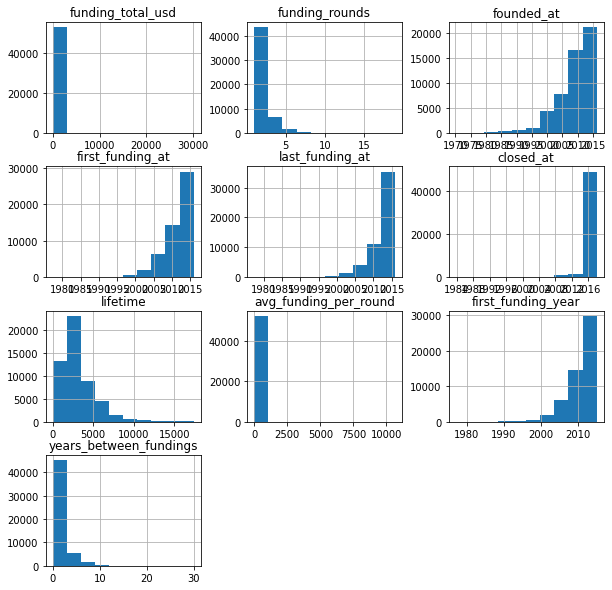

In [32]:
data_train.hist(figsize=(10, 10));

Из гистограмм выше, видно, что в некоторых данных есть выбивающиеся значения. Рассмотрим данные подробнее.

In [33]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,avg_funding_per_round,first_funding_year,years_between_fundings
0,Lunchgate,"media & entertainment, tech",0.828626,operating,CHE,25,Europe,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,0.414313,2011,4.0
1,EarLens,"goods and services, health",42.935019,operating,USA,CA,North America,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,10.733755,2010,4.0
2,Reviva Pharmaceuticals,tech,35.456381,operating,USA,CA,North America,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,11.818794,2012,2.0
3,Sancilio and Company,social,22.250000,operating,unknown,unknown,Other,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,7.416667,2011,3.0
4,WireTough Cylinders,goods and services,0.000000,operating,USA,VA,North America,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,0.000000,2012,0.0


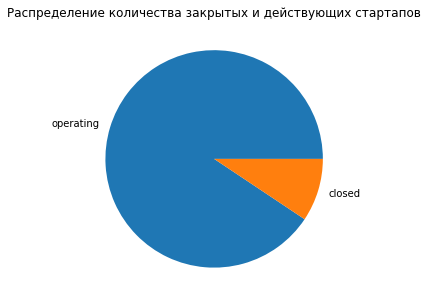

In [34]:
data_train.value_counts('status').plot(y = 'count', kind='pie', 
                        figsize=(5, 5), label='', title = 'Распределение количества закрытых и действующих стартапов' )
plt.show()


Как видно из графика, в тренировочном датафрейме подавляющее большинство составляют действующие стартапы.

,funding_total_usd
count,52516.000000
mean,14.748854
std,168.378343
min,0.000000
25%,0.040000
50%,1.000000
75%,6.788929
max,30079.503000


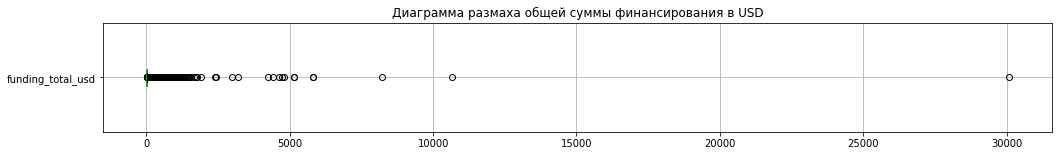

In [35]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_train[['funding_total_usd']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха общей суммы финансирования в USD');
display(data_train[['funding_total_usd']].describe())

В данных есть одно сильно большое, выбивающиеся значение. Это может быть обусловлено исключительным стартапом с очень высоким финансированием, либо ошибкой в данных. Средняя сумма финансирования составляет около 14.7 миллионов долларов.  
Медианное значение (1 миллион долларов) показывает, что половина стартапов получили финансирование менее этой суммы, что значительно ниже среднего значения, подтверждая наличие нескольких стартапов с очень высокими суммами финансирования.  
Максимальное значение финансирования (30 миллиардов долларов).  
Эти данные показывают, что большинство стартапов получают относительно небольшие суммы финансирования, в то время как несколько стартапов получают чрезвычайно большие суммы, значительно влияя на среднее значение.  

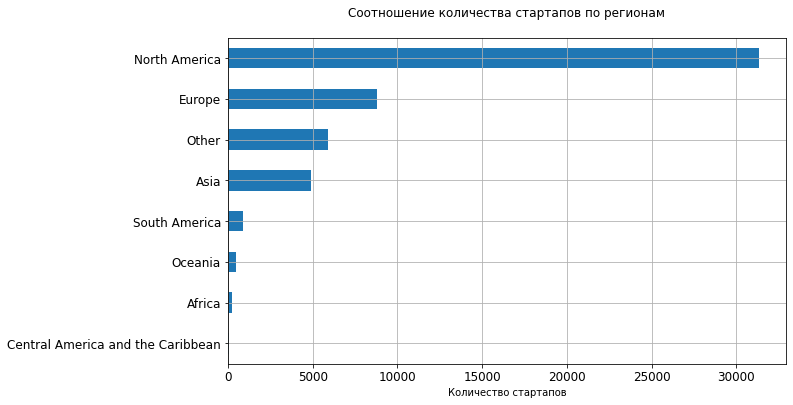

In [36]:
data_train.pivot_table(index = 'region', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по регионам' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


Большое количество стартапов приходится на Северную Америку, следом идет Европа, затем категория, куда были отнесены стартапы с отсутствующими значениями.

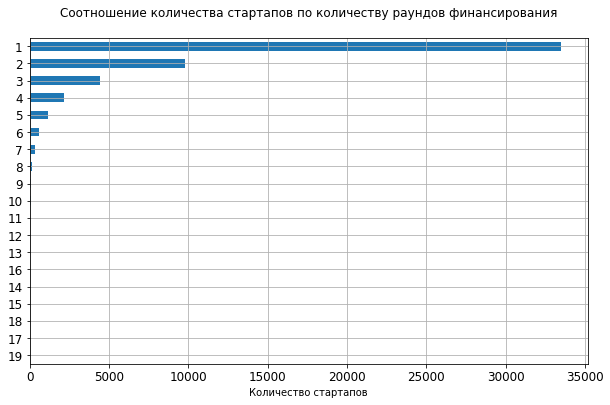

In [37]:
data_train.pivot_table(index = 'funding_rounds', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по количеству раундов финансирования' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


,lifetime
count,52516.000000
mean,3140.828129
std,2147.821070
min,19.000000
25%,1739.000000
50%,2557.000000
75%,4018.000000
max,17378.000000


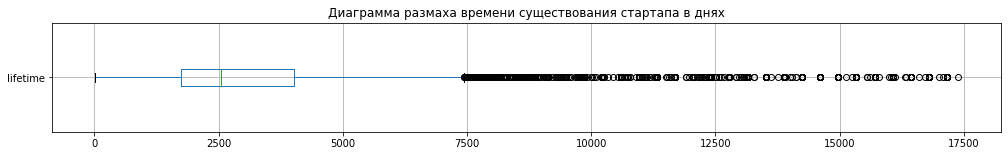

In [38]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_train[['lifetime']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха времени существования стартапа в днях');
display(data_train[['lifetime']].describe())

Средняя продолжительность деятельности стартапов составляет примерно 3 141 день (около 8,6 лет), при этом стандартное отклонение равно 2 148 дням (около 5,9 лет). Минимальный срок существования составляет 19 дней, а максимальный — 17 378 дней (около 47,6 лет). Медианное значение равно 2 557 дням (около 7 лет), что свидетельствует о том, что половина стартапов существовала менее 7 лет.

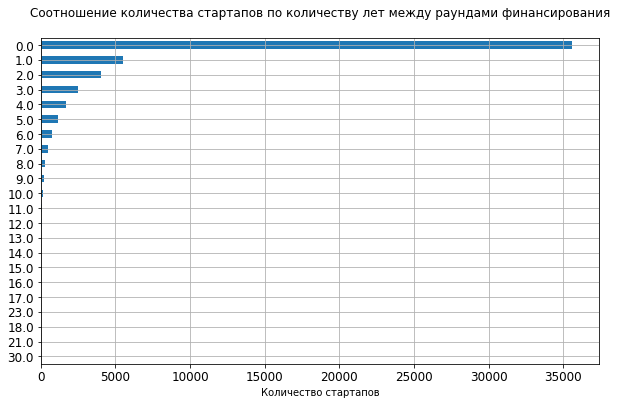

In [39]:
data_train.pivot_table(index = 'years_between_fundings', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по количеству лет между раундами финансирования' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


#### Статистический анализ таблицы data_test

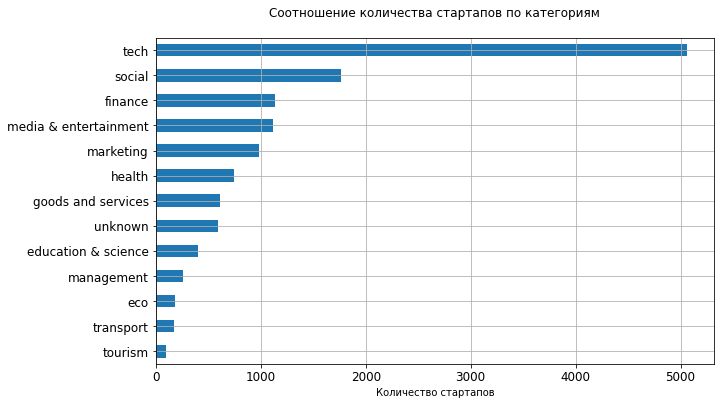

In [40]:
data_test.pivot_table(index = 'category_list', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по категориям' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


Больше всего стартапов в категории "Технологии", затем "Социальные" и примерно равное количество у "Финансы" и "Медиа и развлечения".

,funding_total_usd
count,13125.000000
mean,13.298544
std,82.886614
min,0.000000
25%,0.040000
50%,0.950000
75%,6.513865
max,4715.000000


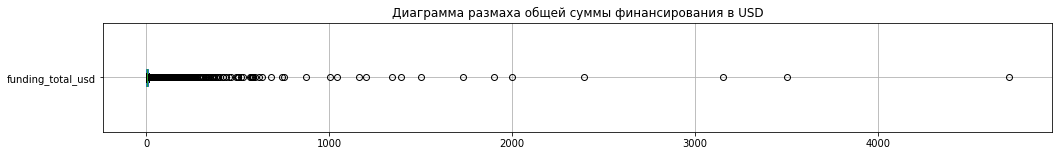

In [41]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_test[['funding_total_usd']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха общей суммы финансирования в USD');
display(data_test[['funding_total_usd']].describe())

Среднее финансирование составляет около 13,3 миллионов долларов, при этом стандартное отклонение равно 82,9 миллионам долларов, что свидетельствует о значительной вариативности в объемах финансирования. Минимальное значение финансирования равно 0 долларов, а максимальное — 4,715 миллиардов долларов. Медианное значение составляет 0,95 миллиона долларов, что указывает на то, что половина стартапов привлекла менее этого значения.

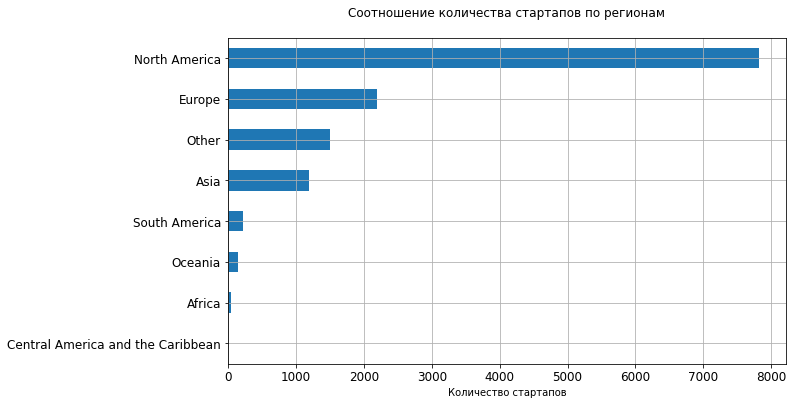

In [42]:
data_test.pivot_table(index = 'region', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по регионам' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


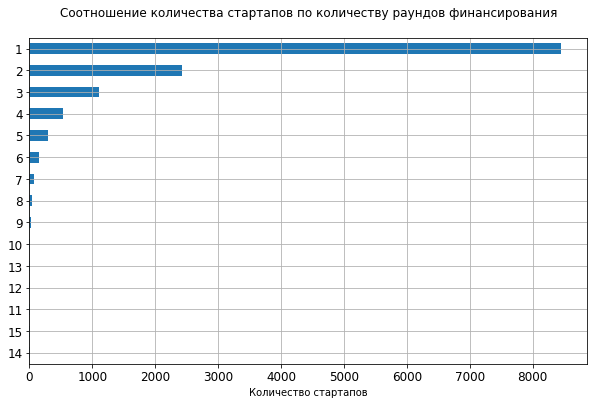

In [43]:
data_test.pivot_table(index = 'funding_rounds', values = 'name', aggfunc='count') \
.sort_values(by = 'name', ascending = True) \
.plot(kind = 'barh', figsize = (10,6), fontsize = 12, grid = True, legend = False)
plt.title(label = 'Соотношение количества стартапов по количеству раундов финансирования' + "\n")
plt.ylabel('')
plt.xlabel('Количество стартапов')
plt.show()


,lifetime
count,13125.000000
mean,3097.609524
std,2128.356554
min,52.000000
25%,1726.000000
50%,2526.000000
75%,3866.000000
max,17167.000000


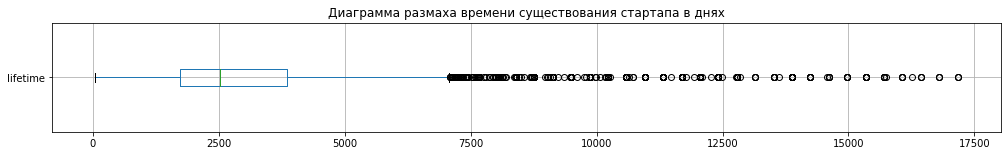

In [44]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_test[['lifetime']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха времени существования стартапа в днях');
display(data_test[['lifetime']].describe())

Средняя продолжительность стартапа составляет около 3097,6 дней (около 8,5 лет). Минимальная продолжительность составляет 52 дня, а максимальная — 17 167 дней (почти 47 лет). Медианное значение составляет 2526 дней (около 7 лет), что означает, что половина стартапов существовала менее этого срока.

* Тренировочный и тестовый датасеты содержат аналогичные данные. Наибольшее число стартапов относится к категории "Технологии", что объясняется перспективностью и инновационностью данного направления. На втором месте по численности находятся социальные стартапы. Категории "Медиа и развлечения" и "Финансы" имеют примерно одинаковое количество стартапов.  
* В данных присутствует одно сильно выбивающееся значение, что может быть обусловлено либо исключительным стартапом с очень высоким финансированием, либо ошибкой в данных. Средняя сумма финансирования составляет около 14.7 миллионов, однако медианное значение составляет всего 1 миллион долларов. Это указывает на то, что половина стартапов получила финансирование менее этой суммы, что значительно ниже среднего значения. Максимальное значение финансирования составляет 30 миллиардов.  
* Большинство стартапов приходится на Северную Америку, следом идет Европа, затем категория, куда были отнесены стартапы с отсутствующими значениями.  
* Средняя продолжительность деятельности стартапов составляет около 8,6 лет. Минимальный срок существования составляет 19 дней, а максимальный — 17 378 дней (около 47,6 лет). Медианное значение равно 2 557 дням (около 7 лет).
* Эти данные подчеркивают, что, несмотря на наличие нескольких стартапов с чрезвычайно высокими суммами финансирования, большинство стартапов получают относительно небольшие суммы и имеют среднюю продолжительность существования около 7-8 лет.  







### Корреляционный анализ

Преобразуем целевой признак `status` в бинарный вид. 
Удалим столбцы с датами и среди схожиех признаки `country_code`, `state_code`,	`city`, `region`  оставим только преобразованный `region`. Так же удалим уникальный столбец `name`

In [45]:
data_train['status_bin'] = data_train['status'].apply \
(lambda x: 1 if x == "operating" else 0)
data_train = data_train.drop([], axis=1)
data_train = data_train.drop(columns=['country_code', 'state_code', 'status', 'name',
                                      'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
data_train.head()

,category_list,funding_total_usd,region,city,funding_rounds,lifetime,avg_funding_per_round,first_funding_year,years_between_fundings,status_bin
0,"media & entertainment, tech",0.828626,Europe,Zürich,2,2998,0.414313,2011,4.0,1
1,"goods and services, health",42.935019,North America,Redwood City,4,4748,10.733755,2010,4.0,1
2,tech,35.456381,North America,San Jose,3,4383,11.818794,2012,2.0,1
3,social,22.250000,Other,unknown,3,5114,7.416667,2011,3.0,1
4,goods and services,0.000000,North America,Bristol,1,2791,0.000000,2012,0.0,1


После удаления стобца name с уникальными значениями, нужно еще раз проверить дубликаты.

In [46]:
data_train.duplicated().sum()

149

Удалим их

In [47]:
data_train.drop_duplicates(inplace=True)

#### Рассчет коэффициентов корреляции между всеми признаками.

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'avg_funding_per_round', 'first_funding_year', 'years_between_fundings', 'status_bin']


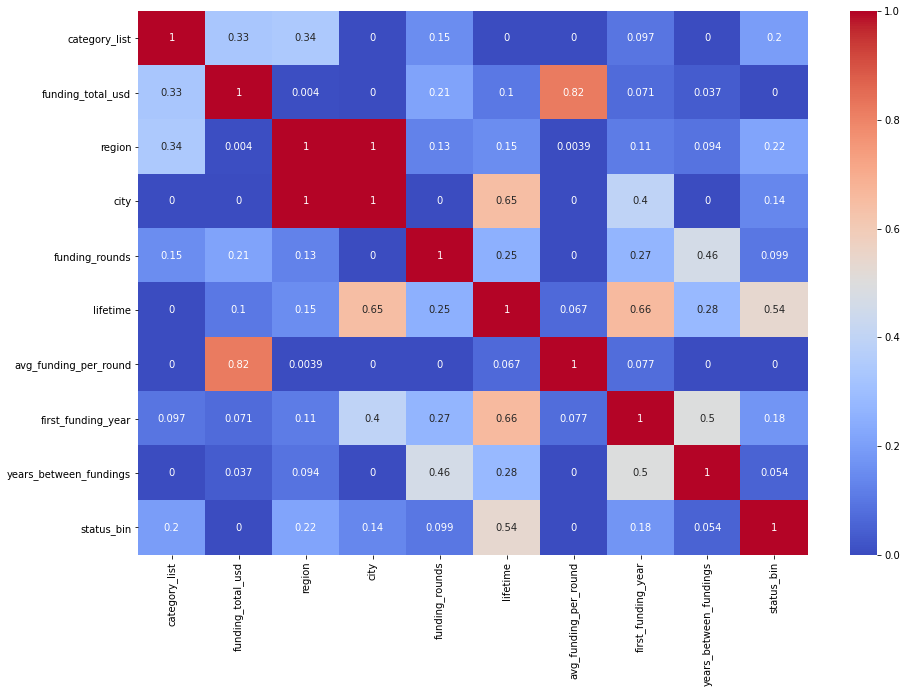

In [48]:
# Вычислим матрицу корреляции с использованием phik
corr_matrix = data_train.phik_matrix()

# Визуализируем матрицу корреляции

plt.figure(figsize = (15, 10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

Существует умеренная положительная корреляция (0,46) между количеством раундов финансирования и годами между раундами. 
Существует сильная положительная корреляция (0,54) между lifetime и status_bin. А так же сильная корреляция (0,66) между lifetime и годом первого финансирования.

Посмотрим на корреляцию открытых и закрытых стартапов отдельно.

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'avg_funding_per_round', 'first_funding_year', 'years_between_fundings', 'status_bin']


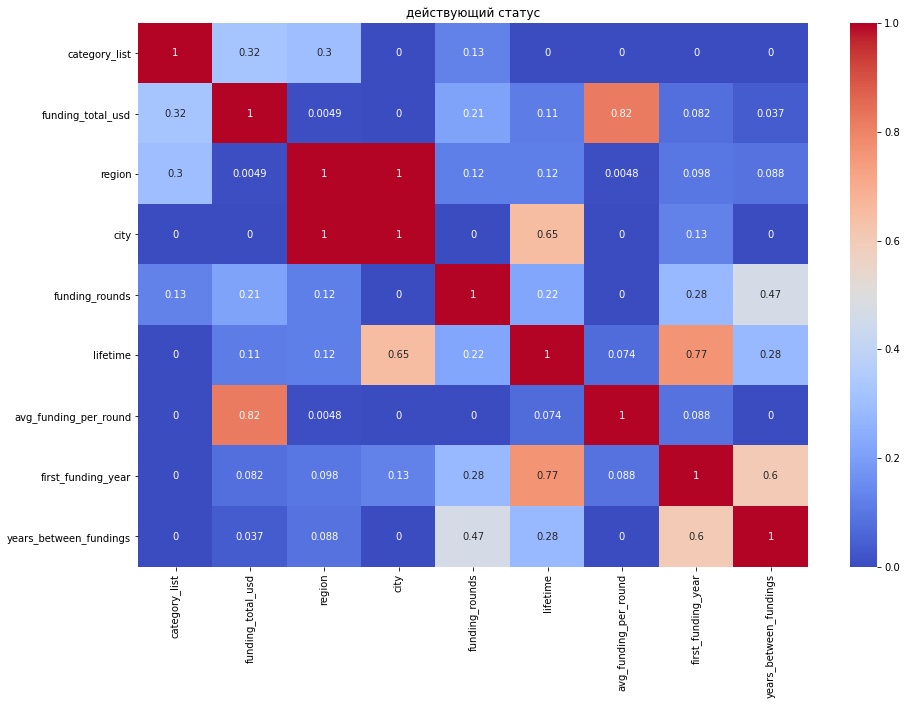

In [49]:
corr_matrix_pr = data_train.query('status_bin == 1').phik_matrix()

# Визуализация матрицы корреляции

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix_pr, annot=True, cmap='coolwarm')
plt.title('действующий статус')
plt.show()

Существует умеренная положительная корреляция (0,47) между количеством раундов финансирования и годами между раундами.  Существует сильная положительная корреляция (0,65) между lifetime и городом. А так же корреляция (0,77) между lifetime и перым годом финансирования.

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'avg_funding_per_round', 'first_funding_year', 'years_between_fundings', 'status_bin']


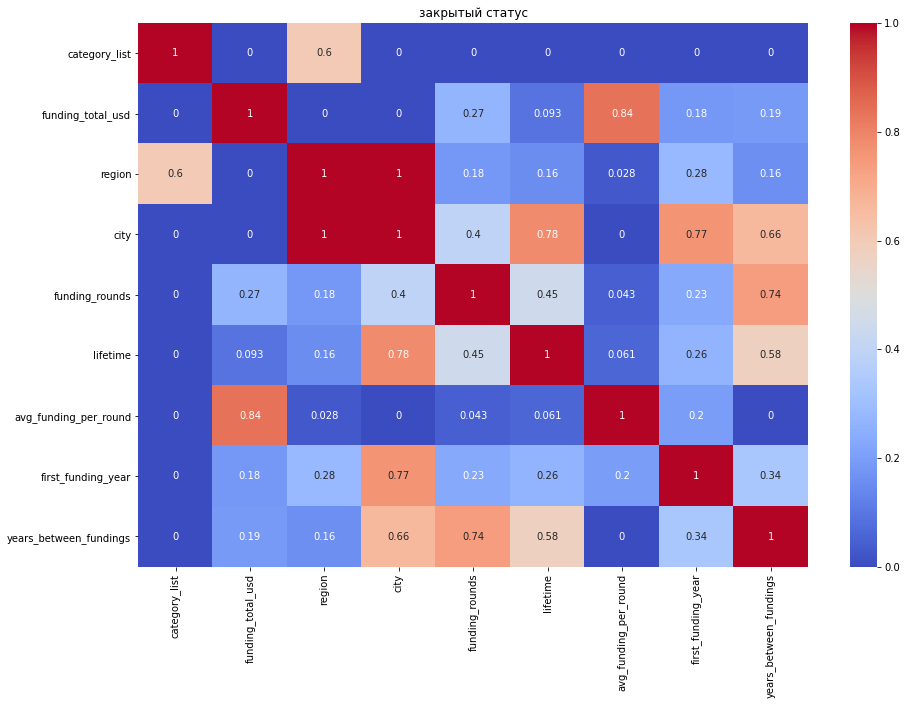

In [50]:
corr_matrix_pr = data_train.query('status_bin == 0').phik_matrix()

# Визуализация матрицы корреляции

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix_pr, annot=True, cmap='coolwarm')
plt.title('закрытый статус')
plt.show()

Существует сильная положительная корреляция (0,74) между количеством раундов финансирования и годами между раундами. Сильная положительная корреляция (0,78) между lifetime и городом, (0,58) между lifetime и годами между раундами, (0,66) между городом и годами между раундами. А так же (0,6) между ркгионом и категорией стартапа.

На всех матрицах корреляции наблюдается мультиколленеарность между городом и регионом. Но при этом регион хорошо коррелирует с категориями стартапа, а город с lifetime и годами между раундами

### Использование пайплайнов

In [51]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52367 entries, 0 to 52515
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category_list           52367 non-null  object 
 1   funding_total_usd       52367 non-null  float64
 2   region                  52367 non-null  object 
 3   city                    52367 non-null  object 
 4   funding_rounds          52367 non-null  int64  
 5   lifetime                52367 non-null  int64  
 6   avg_funding_per_round   52367 non-null  float64
 7   first_funding_year      52367 non-null  int64  
 8   years_between_fundings  52367 non-null  float64
 9   status_bin              52367 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 4.4+ MB


In [52]:
# загружаем данные
TEST_SIZE = 0.25

X = data_train.drop(['status_bin'], axis=1)
y = data_train['status_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_train['status_bin']
)

X_train.shape, X_test.shape

((39275, 9), (13092, 9))

In [53]:
# создаем экземпляр класса RandomOverSampler с фиксированным random_state
sampler = RandomOverSampler(random_state=42)

# сэмплируем данные методов оверсэмплинга одной командой
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train,y_train) 

print(f'Тренировочные данные до сэмплирования:\n{y_train.value_counts()}')
print(f'\nТренировочные данные после сэмплирования:\n{y_train_sampled.value_counts()}')

Тренировочные данные до сэмплирования:
1    35592
0     3683
Name: status_bin, dtype: int64

Тренировочные данные после сэмплирования:
0    35592
1    35592
Name: status_bin, dtype: int64


In [54]:
# создаём списки с названиями признаков

ohe_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()


In [55]:
RANDOM_STATE = 50


# Создание пайплайна для обработки признаков
ohe_pipeline = Pipeline(
    [
        ('encoder_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('categorical', ohe_pipeline, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])       
   

In [56]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },

    # словарь для модели LogisticRegression()
    {   
        'models': [LogisticRegression(random_state=42, solver='liblinear', penalty='l1')],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
     },
    
    # словарь для модели CatBoostClassifier()    
        {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__iterations': [100, 200, 300],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [57]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
   )
randomized_search.fit(X_train_sampled, y_train_sampled)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder_ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['category_list', 'region',
                                                   'city']),
                                                 ('num', 'passthrough',
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                                                   'avg_funding_per_round',
                                                   'first_funding_year',
          

In [58]:
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика f1 score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика f1 score на тестовой выборке: 0.9817243421609273


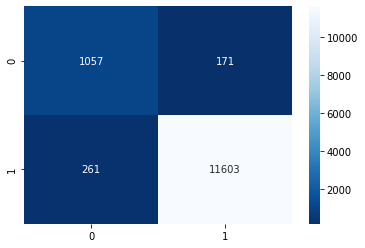

In [59]:
y_test_pred = randomized_search.predict(X_test)
cm =  confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
 

In [60]:
# Загрузка лучшей модели
best_model = randomized_search.best_estimator_
# Применение модели к data_test
data_test['status'] = best_model.predict(data_test)
data_test['status'] = data_test['status'].apply \
(lambda x: "operating" if x == 1 else "closed")
data_test = data_test.drop(columns=['category_list', 'funding_total_usd', 'country_code', 'state_code', 'city', 'funding_rounds',
                                    'region', 'first_funding_at', 'last_funding_at', 'lifetime', 
                                    'years_between_fundings','avg_funding_per_round','first_funding_year'])

# Вывод прогнозов
data_test.head()

,name,first_funding_year,status
0,Crystalsol,2009,operating
1,JBI Fish & Wings,2010,operating
2,COINPLUS,2014,operating
3,Imagine Communications,2005,operating
4,DNA13,2007,operating


In [62]:
data_test = data_test.drop(columns=['first_funding_year'])

In [64]:
# Сохраните DataFrame в CSV файл
data_test.to_csv('predictions.csv', index=False)

### Вывод

**Цель исследования:** Целью данного проекта было предсказать успешность стартапа (закроется он или нет) на основе различных характеристик стартапов, таких как регион, категория, количество раундов финансирования и другие.

**Методы и подходы:** 
1. **Подготовка данных:** Были обработаны пропуски в данных и приведены столбцы с датами к соответствующему виду. Категориальные переменные, такие как `category_list`, `city` и `region`, были закодированы с использованием метода OneHotEncoder. Также был добавлены новые признаки — количество лет между первым и последним раундом финансирования, а также среднее финансирование на раунд.
   
3. **Построение моделей:** Были исследованы различные модели машинного обучения, включая DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, CatBoostClassifier. Для каждой модели был настроен набор гиперпараметров с использованием RandomizedSearchCV.

4. **Оценка моделей:** Лучшая модель была выбрана на основе метрики f1-score. .

**Результаты:**
- Лучшая модель показала достаточно высокий уровень точности на тренировочной и тестовой выборках.
- Важнейшие признаки для предсказания успешности стартапа включают регион, категорию стартапа, количество раундов финансирования, количество лет между первым и последним раундом финансирования и первый год финансирования.

**Заключение:**
Полученные результаты демонстрируют, что предложенный подход с использованием различных методов машинного обучения и тщательной подготовки данных позволяет эффективно предсказывать успешность стартапов. Важность таких признаков, как регион и категория стартапа, первый год финансирования подчеркивает необходимость более детального анализа этих факторов при оценке перспективности новых стартапов. В будущем целесообразно продолжить исследование с использованием дополнительных данных и методов для дальнейшего повышения точности предсказаний и понимания ключевых факторов, влияющих на успешность стартапов.